# **Modelo de regresión con caracteristicas polinomicas**
## Desarrollado por Jesus David Gomez Osorno
## Universidad de Antioquia

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
RUTA_DATA = '/content/drive/MyDrive/Monografía/data'
RUTA_DATA_MEDIANOS = RUTA_DATA + '/medianos'
RUTA_DATA_GRANDES = RUTA_DATA + '/grandes'
RUTA_RESULTADOS_MEDIANOS = RUTA_DATA + '/resultados/medianos'
RUTA_RESULTADOS_GRANDES = RUTA_DATA + '/resultados/grandes'

## 1. Caracteristicas

In [20]:
DEPARTAMENTO = 'DEPARTAMENTO'
MUNICIPIO = 'MUNICIPIO'
GRUPO_CULTIVO = 'GRUPO_CULTIVO'
CULTIVO = 'CULTIVO'
AREA_SEMBRADA = 'AREA_SEMBRADA'
AREA_COSECHADA = 'AREA_COSECHADA'
PRODUCCION = 'PRODUCCION'
ESTADO_FISICO_PRODUCCION = 'ESTADO_FISICO_PRODUCCION'
CICLO_CULTIVO = 'CICLO_CULTIVO'

In [21]:
columns = [
            DEPARTAMENTO,
            MUNICIPIO,
            GRUPO_CULTIVO,
            CULTIVO,
            AREA_SEMBRADA,
            AREA_COSECHADA,
            PRODUCCION,            
            ESTADO_FISICO_PRODUCCION,
            CICLO_CULTIVO
          ]

columns_feature = [
            DEPARTAMENTO,
            MUNICIPIO,
            GRUPO_CULTIVO,
            CULTIVO,
            AREA_COSECHADA,
            PRODUCCION,            
            ESTADO_FISICO_PRODUCCION,
            CICLO_CULTIVO
          ]

In [22]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

##Función de metricas

In [23]:
from sklearn.model_selection import cross_val_score # Método de validación cruzada para evaluar el desempeño un modelo
from sklearn.model_selection import cross_val_score
from sklearn.metrics import explained_variance_score # Se llama a una clase llamada explained_variance_score, el cual es
                                                     # una métrica de varianza explicada
from sklearn.metrics import mean_absolute_error # Se llama a una clase llamada mean_absolute_error, el cual es
                                                # una métrica de error promedio absoluto
from sklearn.metrics import mean_gamma_deviance # 0.001 (Sensibilidad del modelo regresión)
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_poisson_deviance                                            

def puntaje(X_Prueba_local, Y_Prueba_local, y_pred_local, estimador, name):
  Puntaje_1_R2 = estimador.score(X_Prueba_local, Y_Prueba_local) 

  # Error cuadrático medio
  Validacion_ECM = cross_val_score(estimador, X_Prueba_local, Y_Prueba_local, cv = 5, scoring = 'neg_mean_squared_error')
  Puntaje_2_ECM = np.array([Validacion_ECM.mean(), Validacion_ECM.std()]) 

  ## R Cuadrado
  Validacion_R2 = cross_val_score(estimador, X_Prueba_local, Y_Prueba_local, cv = 10, scoring = 'r2')
  Puntaje_3_R2 = np.array([Validacion_R2.mean(), Validacion_R2.std()]) 

  ## Varianza Explicada
  Puntaje_4 = explained_variance_score(Y_Prueba_local, y_pred_local) 
  ## ECM
  Puntaje_5 = mean_absolute_error(Y_Prueba_local, y_pred_local) 

  ## Pérdida media de regresión de la desviación de Poisson
  MN = MinMaxScaler(feature_range=(0, 1))

  Y_Prueba_R = Y_Prueba_local.values
  Y_Prueba_R = np.asarray(Y_Prueba_R)
  Y_merge = np.vstack([Y_Prueba_R, y_pred_local]).T
  Y_merge = MN.fit_transform(Y_merge)

  for _,n in enumerate(np.arange(0, Y_merge.shape[0])):
    if Y_merge[n,0] == 0:
      Y_merge[n,0] = 0.0001
    if Y_merge[n,1] == 0:
      Y_merge[n,1] = 0.0001

  Puntaje_6 = mean_poisson_deviance(Y_merge[:,0], Y_merge[:,1]) 
  Puntaje_7 = mean_gamma_deviance(Y_merge[:,0], Y_merge[:,1])

  return {'NOMBRE': name, 
          'R2_MODEL': Puntaje_1_R2, 
          'CROSS_ECM': Puntaje_2_ECM[0], 
          'CROSS_ECM_DE': Puntaje_2_ECM[1], 
          'CROSS_R2': Puntaje_3_R2[0], 
          'CROSS_R2_DE': Puntaje_3_R2[1],
          'VARIANZA_EXPL': Puntaje_4,
          'MAE': Puntaje_5,
          'MAE_POISSON': Puntaje_6,
          'MAE_GAMMA': Puntaje_7}


## Función grafica mejor

In [24]:
from sklearn.linear_model import LinearRegression # Algoritmo para crear el modelo de regresión lineal múltiple
from sklearn.preprocessing import PolynomialFeatures # Características Polinomiales

def grafica_mejor(url, opc):
  data_after = pd.read_csv(url, header = None, index_col= False, names = columns)
  data_after_features = data_after[columns_feature]
  data_after_estimados = data_after[AREA_SEMBRADA]

  X_Entrenamiento, X_Prueba, Y_Entrenamiento, Y_Prueba = train_test_split(data_after_features, data_after_estimados, test_size = 0.2, random_state = 17)
  
  Modelo_Polinomico = PolynomialFeatures(degree = opc, interaction_only=True)                                                                 
  X_poly_entrenamiento = Modelo_Polinomico.fit_transform(X_Entrenamiento) # Transformamos los datos de las características de los datos en datos con características polinomiales
  X_poly_prueba = Modelo_Polinomico.fit_transform(X_Prueba)

  LR = LinearRegression()
  LR.fit(X_poly_entrenamiento, Y_Entrenamiento) 

  Y_pred = LR.predict(X_poly_prueba)

  fig = plt.figure(figsize=(12,8))
  line_1 = plt.plot(np.arange(len(Y_Prueba)), Y_Prueba, color = 'g', label='Y original') 
  line_2 = plt.plot(np.arange(len(Y_Prueba)), Y_pred, color = 'r', label='Y estimada por el modelo con regresión características polinómicas') 
  plt.axhline(0, color="black") # Elegir color de la linea horizontal de referencia
  plt.legend()
  plt.title('Comparación entre Y salida original vs Y salida del modelo con regresión características polinómicas') # Titulo de la gráfica
  plt.xlabel('muestras') # Etiqueta del eje x
  plt.ylabel('y') # Etiqueta del eje y

  plt.show() # Mostrar gráfica

##Función de guardadado de resultados

In [25]:
from os.path import exists

def guardaResultados(url, filename, data):
  if not exists(url):
    np.savetxt(url, data, delimiter=',')

  data_after = pd.read_csv(url, header = None, index_col= False, names = columns_resultados)
  data_after = data_after[data_after['NOMBRE'] == filename ]

  if not len(data_after) > 0:
    print('dentro')
    np.savetxt(url, data, delimiter=',', fmt="%s")
  
  return len(data_after) > 0, pd.concat([data, data_after]);

##Medianos

In [26]:
import os
from sklearn.model_selection import train_test_split # Esta clase realiza la partición de datos en entrenamiento y prueba

columns_resultados = ['NOMBRE', 'CONFIG', 'R2_MODEL', 'CROSS_ECM', 'CROSS_ECM_DE', 'CROSS_R2', 'CROSS_R2_DE', 'VARIANZA_EXPL', 'MAE', 'MAE_POISSON', 'MAE_GAMMA']

In [27]:
df_resultados_medianos = pd.DataFrame(columns=columns_resultados, index=None)

for filename in os.listdir(RUTA_DATA_MEDIANOS):
    if filename.endswith("csv"): 
      print(filename)
      is_save, new_data = guardaResultados(RUTA_RESULTADOS_MEDIANOS + '/caracteristicas_polinomicas.csv', filename, df_resultados_medianos )
      df_resultados_medianos = new_data
      if not is_save:
        url = RUTA_DATA_MEDIANOS + '/' + filename
        data_after = pd.read_csv(url, header = None, index_col= False, names = columns)
        data_after_features = data_after[columns_feature]
        data_after_estimados = data_after[AREA_SEMBRADA]

        X_Entrenamiento, X_Prueba, Y_Entrenamiento, Y_Prueba = train_test_split(data_after_features, data_after_estimados, test_size = 0.2, random_state = 17)
        opcionesPolimonicas = [2, 3, 4, 5, 6]

        for opc in opcionesPolimonicas:
          Modelo_Polinomico = PolynomialFeatures(degree = opc, interaction_only=True)                                                                 

          X_poly_entrenamiento = Modelo_Polinomico.fit_transform(X_Entrenamiento) # Transformamos los datos de las características de los datos en datos con características polinomiales
          X_poly_prueba = Modelo_Polinomico.fit_transform(X_Prueba)

          LR = LinearRegression()
          LR.fit(X_poly_entrenamiento, Y_Entrenamiento) 

          Y_pred = LR.predict(X_poly_prueba)

          result = puntaje(X_poly_prueba, Y_Prueba, Y_pred, LR, filename)
          result['CONFIG'] = opc
          df_resultados_medianos = df_resultados_medianos.append(result, ignore_index=True)

robusto_original.csv
estandar_original.csv
min_max_original.csv
max_normalizacion_original.csv
robusto_lof_euclidean_5.csv
robusto_lof_minkowski_5.csv
robusto_lof_manhattan_5.csv
robusto_lof_euclidean_7.csv
robusto_lof_minkowski_7.csv
robusto_lof_manhattan_7.csv
robusto_lof_euclidean_9.csv
robusto_lof_minkowski_9.csv
robusto_lof_manhattan_9.csv
robusto_lof_euclidean_11.csv
robusto_lof_minkowski_11.csv
robusto_lof_manhattan_11.csv
estandar_lof_euclidean_5.csv
estandar_lof_minkowski_5.csv
estandar_lof_manhattan_5.csv
estandar_lof_euclidean_7.csv
estandar_lof_minkowski_7.csv
estandar_lof_manhattan_7.csv
estandar_lof_euclidean_9.csv
estandar_lof_minkowski_9.csv
estandar_lof_manhattan_9.csv
estandar_lof_euclidean_11.csv
estandar_lof_minkowski_11.csv
estandar_lof_manhattan_11.csv
min_max_lof_euclidean_5.csv
min_max_lof_minkowski_5.csv
min_max_lof_manhattan_5.csv
min_max_lof_euclidean_7.csv
min_max_lof_minkowski_7.csv
min_max_lof_manhattan_7.csv
min_max_lof_euclidean_9.csv
min_max_lof_minkows

In [28]:
pd.set_option("min_rows", 20)
df_resultados_medianos_sort = df_resultados_medianos.sort_values('MAE', False)
df_resultados_medianos_sort

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_values except for the argument 'by' will be keyword-only
  


,NOMBRE,CONFIG,R2_MODEL,CROSS_ECM,CROSS_ECM_DE,CROSS_R2,CROSS_R2_DE,VARIANZA_EXPL,MAE,MAE_POISSON,MAE_GAMMA
555,min_max_isf_400_0_2.csv,2,8.372660e-01,-9.790712e-06,1.414868e-06,8.355645e-01,3.279193e-02,8.373139e-01,1.837465e-03,0.037255,1.013880e+00
480,min_max_isf_100_0_2.csv,2,8.410863e-01,-1.022073e-05,5.583332e-07,8.388218e-01,1.580671e-02,8.410932e-01,1.842470e-03,0.026234,1.365947e+00
507,min_max_isf_200_0_2.csv,4,8.350124e-01,-4.665617e+07,6.090759e+07,-1.245054e+13,3.735161e+13,8.350457e-01,1.849489e-03,0.034060,6.030431e-01
481,min_max_isf_100_0_2.csv,3,8.416550e-01,-6.095483e+01,1.140361e+02,-2.539594e+09,7.594080e+09,8.416550e-01,1.849509e-03,0.024960,1.283484e+00
506,min_max_isf_200_0_2.csv,3,8.354685e-01,-4.214004e+08,8.333034e+08,-2.849313e+14,8.547940e+14,8.354905e-01,1.852149e-03,0.030385,6.206161e-01
505,min_max_isf_200_0_2.csv,2,8.338159e-01,-1.025252e-05,1.242143e-06,8.320054e-01,2.953264e-02,8.338401e-01,1.860559e-03,0.030226,1.187206e+00
509,min_max_isf_200_0_2.csv,6,8.188191e-01,-1.071631e+08,2.115251e+08,-1.162661e+11,3.487963e+11,8.188382e-01,1.860966e-03,0.068945,1.777704e+00
533,min_max_isf_300_0_2.csv,5,8.395176e-01,-3.148231e+13,6.296463e+13,-1.028930e+14,3.086789e+14,8.395193e-01,1.862428e-03,0.029562,5.360296e-01
532,min_max_isf_300_0_2.csv,4,8.412680e-01,-2.473773e+13,4.947546e+13,-2.835195e+17,8.505585e+17,8.412688e-01,1.864109e-03,0.031270,6.133708e-01
531,min_max_isf_300_0_2.csv,3,8.410130e-01,-3.203174e+12,6.406349e+12,-4.753366e+17,1.426010e+18,8.410170e-01,1.866484e-03,0.029439,7.365900e-01


### Mejor resultado

In [29]:
df_resultados_medianos_sort.head(1)

,NOMBRE,CONFIG,R2_MODEL,CROSS_ECM,CROSS_ECM_DE,CROSS_R2,CROSS_R2_DE,VARIANZA_EXPL,MAE,MAE_POISSON,MAE_GAMMA
555,min_max_isf_400_0_2.csv,2,0.837266,-0.00001,0.000001,0.835564,0.032792,0.837314,0.001837,0.037255,1.01388


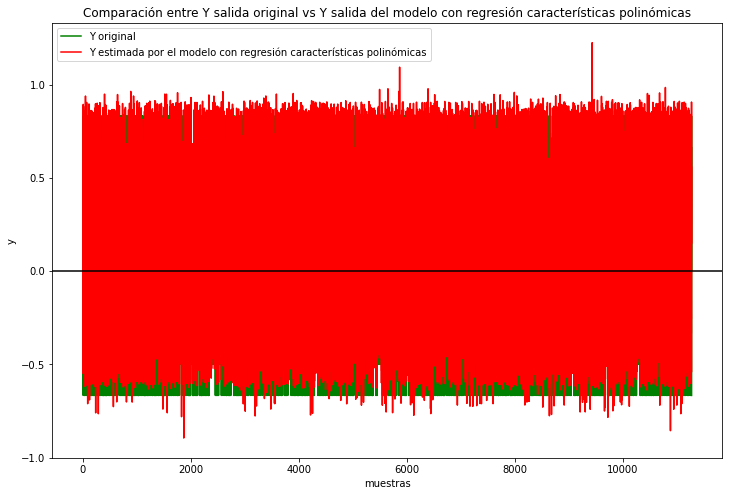

In [30]:
url = RUTA_DATA_MEDIANOS + '/' + df_resultados_medianos_sort.at[0,'NOMBRE']
opc = df_resultados_medianos_sort.at[0,'CONFIG']
grafica_mejor(url, opc)

## Grandes

In [31]:
df_resultados_grandes = pd.DataFrame(columns=columns_resultados, index=None)

for filename in os.listdir(RUTA_DATA_GRANDES):
    if filename.endswith("csv"): 
      print(filename)
      is_save, new_data = guardaResultados(RUTA_RESULTADOS_GRANDES + '/caracteristicas_polinomicas.csv', filename, df_resultados_grandes )
      df_resultados_grandes = new_data
      if not is_save:
        url = RUTA_DATA_GRANDES + '/' + filename
        data_after = pd.read_csv(url, header = None, index_col= False, names = columns)
        data_after_features = data_after[columns_feature]
        data_after_estimados = data_after[AREA_SEMBRADA]

        X_Entrenamiento, X_Prueba, Y_Entrenamiento, Y_Prueba = train_test_split(data_after_features, data_after_estimados, test_size = 0.2, random_state = 17)
        opcionesPolimonicas = [2, 3, 4, 5, 6]

        for opc in opcionesPolimonicas:
          Modelo_Polinomico = PolynomialFeatures(degree = opc, interaction_only=True)                                                                 

          X_poly_entrenamiento = Modelo_Polinomico.fit_transform(X_Entrenamiento) # Transformamos los datos de las características de los datos en datos con características polinomiales
          X_poly_prueba = Modelo_Polinomico.fit_transform(X_Prueba)

          LR = LinearRegression()
          LR.fit(X_poly_entrenamiento, Y_Entrenamiento) 

          Y_pred = LR.predict(X_poly_prueba)

          result = puntaje(X_poly_prueba, Y_Prueba, Y_pred, LR, filename)
          result['CONFIG'] = opc
          df_resultados_grandes = df_resultados_grandes.append(result, ignore_index=True)

robusto_original.csv
estandar_original.csv
min_max_original.csv
max_normalizacion_original.csv
robusto_lof_euclidean_5.csv
robusto_lof_minkowski_5.csv
robusto_lof_manhattan_5.csv
robusto_lof_euclidean_7.csv
robusto_lof_minkowski_7.csv
robusto_lof_manhattan_7.csv
robusto_lof_euclidean_9.csv
robusto_lof_minkowski_9.csv
robusto_lof_manhattan_9.csv
robusto_lof_euclidean_11.csv
robusto_lof_minkowski_11.csv
robusto_lof_manhattan_11.csv
estandar_lof_euclidean_5.csv
estandar_lof_minkowski_5.csv
estandar_lof_manhattan_5.csv
estandar_lof_euclidean_7.csv
estandar_lof_minkowski_7.csv
estandar_lof_manhattan_7.csv
estandar_lof_euclidean_9.csv
estandar_lof_minkowski_9.csv
estandar_lof_manhattan_9.csv
estandar_lof_euclidean_11.csv
estandar_lof_minkowski_11.csv
estandar_lof_manhattan_11.csv
min_max_lof_euclidean_5.csv
min_max_lof_minkowski_5.csv
min_max_lof_manhattan_5.csv
min_max_lof_euclidean_7.csv
min_max_lof_minkowski_7.csv
min_max_lof_manhattan_7.csv
min_max_lof_euclidean_9.csv
min_max_lof_minkows

In [32]:
pd.set_option("min_rows", 20)
df_resultados_grandes_sort = df_resultados_grandes.sort_values('MAE', False)
df_resultados_grandes_sort

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_values except for the argument 'by' will be keyword-only
  


,NOMBRE,CONFIG,R2_MODEL,CROSS_ECM,CROSS_ECM_DE,CROSS_R2,CROSS_R2_DE,VARIANZA_EXPL,MAE,MAE_POISSON,MAE_GAMMA
145,min_max_lof_minkowski_5.csv,2,9.604706e-01,-3.516857e-05,1.120606e-05,9.617588e-01,2.797403e-02,9.604711e-01,0.001155,0.001444,0.982993
140,min_max_lof_euclidean_5.csv,2,9.604706e-01,-3.516857e-05,1.120606e-05,9.617588e-01,2.797403e-02,9.604711e-01,0.001155,0.001444,0.982993
150,min_max_lof_manhattan_5.csv,2,9.701099e-01,-2.743672e-05,1.388078e-05,9.710866e-01,1.774176e-02,9.701124e-01,0.001156,0.001122,0.915578
189,min_max_lof_euclidean_11.csv,6,9.625704e-01,-4.246745e-05,2.285585e-05,9.473425e-01,2.661404e-02,9.625714e-01,0.001163,0.019614,3.318598
194,min_max_lof_minkowski_11.csv,6,9.625704e-01,-4.246745e-05,2.285585e-05,9.473425e-01,2.661404e-02,9.625714e-01,0.001163,0.019614,3.318598
185,min_max_lof_euclidean_11.csv,2,9.616523e-01,-3.079324e-05,1.536875e-05,9.611762e-01,2.527731e-02,9.616524e-01,0.001166,0.001088,0.727311
190,min_max_lof_minkowski_11.csv,2,9.616523e-01,-3.079324e-05,1.536875e-05,9.611762e-01,2.527731e-02,9.616524e-01,0.001166,0.001088,0.727311
153,min_max_lof_manhattan_5.csv,5,9.711439e-01,-3.564909e-05,1.865987e-05,9.646689e-01,1.860944e-02,9.711464e-01,0.001168,0.016009,3.231103
188,min_max_lof_euclidean_11.csv,5,9.622570e-01,-3.932466e-05,2.517825e-05,9.545999e-01,2.305677e-02,9.622578e-01,0.001169,0.017700,3.199446
193,min_max_lof_minkowski_11.csv,5,9.622570e-01,-3.932466e-05,2.517825e-05,9.545999e-01,2.305677e-02,9.622578e-01,0.001169,0.017700,3.199446


### Mejor resultado

In [33]:
df_resultados_grandes_sort.head(1)

,NOMBRE,CONFIG,R2_MODEL,CROSS_ECM,CROSS_ECM_DE,CROSS_R2,CROSS_R2_DE,VARIANZA_EXPL,MAE,MAE_POISSON,MAE_GAMMA
145,min_max_lof_minkowski_5.csv,2,0.960471,-0.000035,0.000011,0.961759,0.027974,0.960471,0.001155,0.001444,0.982993


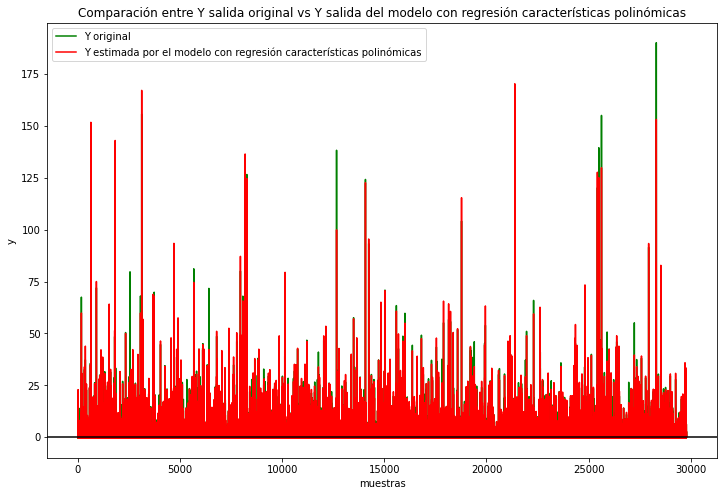

In [34]:
url = RUTA_DATA_GRANDES + '/' + df_resultados_grandes_sort.at[0,'NOMBRE']
opc = df_resultados_grandes_sort.at[0,'CONFIG']
grafica_mejor(url, opc)